In [3]:
import json
import csv
import pandas as pd

groundTruthfile = "./test.tsv"

groundTruthDict = {}
with open(groundTruthfile, "r") as f:
    tsv_file = csv.reader(f,delimiter="\t")
    for line in tsv_file:
        (curr_turn,rel_turn) = line[0],line[1]
        if curr_turn in groundTruthDict:
            groundTruthDict[curr_turn].append(rel_turn)
        else:
            groundTruthDict[curr_turn] = []
            if rel_turn != 'x':
                groundTruthDict[curr_turn].append(rel_turn)

# print(groundTruthDict)

no_of_relation = 0
for key, value in groundTruthDict.items():
    no_of_relation += len(value)
print(no_of_relation)

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


633


In [ ]:
from allennlp.predictors.predictor import Predictor

from allennlp.predictors.predictor import Predictor
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_url = "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz"
predictor = Predictor.from_path(model_url)

sentBertModel = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def query_coref_resolved(query, file_name):
    text =  '\t'.join(query)
    resolved_text = predictor.coref_resolved(text)
    return resolved_text.split("\t")[-1]

def write_topic_wise_tsv_file(combined_json_file):
    json_file = open(combined_json_file)
    dataDict = json.load(json_file)

    for eachTopic in dataDict:
        topicNumber = eachTopic['number']
        historyContext = []

        with open('./data/' + str(topicNumber) + '.tsv', "w", newline="", encoding="utf-8") as opfile:
            writer = csv.writer(opfile, delimiter="\t")
            rowWiseData = []

            for turn in eachTopic['turn']:
                turnDepth = turn['number']
                turnUtterance = turn['raw_utterance']
                historyContext.append(turnUtterance)
                rowWiseData.append(
                    [
                        str(topicNumber) + "_" + str(turnDepth),
                        turnUtterance,
                        query_coref_resolved(historyContext)
                    ]
                )
            writer.writerows(rowWiseData)

In [87]:
def topicWise_query_similarity(topicNumber):
    for files in topicNumber:
        fileToRead = './data/'+str(files)+'.tsv'
        topic_df = pd.read_csv(fileToRead, sep="\t", header=None)
        raw_utterance = topic_df[1]
        coref_utterance = topic_df[2]

        embeddings1 = sentBertModel.encode(list(raw_utterance))
        embeddings2 = sentBertModel.encode(list(coref_utterance))

        cosine_scores = util.cos_sim(embeddings1, embeddings1)
        coref_cosine_scores = util.cos_sim(embeddings2, embeddings2)

        pd.DataFrame(cosine_scores.numpy()).to_csv(
            './data/cosineSim/Cosine_Scores_' + str(files) + '.csv', index=False)
        pd.DataFrame(coref_cosine_scores.numpy()).to_csv(
            './data/corefCosineSim/Coref_Cosine_Scores_' + str(files) + '.csv', index=False)

        plot_heatmap(cosine_scores, 'Cosine_Similarity', files)
        plot_heatmap(coref_cosine_scores, 'Coref_Cosine_Similarity', files)


def plot_clusterMap(simMatrix, type, topicNumber):
    sns.clustermap(simMatrix)
    plt.savefig('./img/'+type+'-' + str(topicNumber) + '.png')
    plt.clf()


def plot_heatmap(simMatrix, type, topicNumber):
    plt.figure(figsize=(30, 30))
    sns.heatmap(
        simMatrix,
        square=True,
        # annot = True,
        cmap='RdYlGn',
        linewidth=0.5,
        center=0.5,
        vmin=-0.00,
        vmax=1.00
    )

    # plt.title(type + str(norm.shape[0]) + " (Sample Size : " + str(file_2_Dataframe.shape[0]) +')' )
    plt.savefig('./img/'+type+'-' + str(topicNumber) + '.png')
    plt.clf()

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.addHandler(logging.FileHandler('./log.log', 'w'))


def sort_dict(simRankDict, simMeasureType):
    index = 1
    if simMeasureType == 'coref_sim':
        index = 2
    for _, value in simRankDict.items():
        value.sort(key=lambda item: item[index], reverse=True)


def filter_dict(allPreviousQuerySimilarityScore, threshold=0.0):
    index = 1
    if simMeasureType == 'coref_sim':
        index = 2
    filtered_list = list(
        filter(
            lambda tup: tup[index] >= threshold,
            allPreviousQuerySimilarityScore
        )
    )

    return filtered_list


def get_ranked_dict(filtered_list, top_rank):
    return filtered_list[:top_rank]


def create_graph(groundTruthDict, allPreviousQuerySimilarityScore):

    groundTruthGraph = nx.DiGraph()
    simGraph = nx.DiGraph()
    corefSimGraph = nx.DiGraph()

    for key, value in allPreviousQuerySimilarityScore.items():
        print(key)
        for nodes in value:
            simGraph.add_edge(key, nodes[0], weight=round(nodes[1], 2))
            corefSimGraph.add_edge(key, nodes[0], weight=round(nodes[2], 2))

        groundTruthGraph.add_node(key)
        groundTruthGraph.add_node(key.split("_")[0]+"_1")


        # print("Nodes: ")
        # print(groundTruthGraph.nodes)
        if key in groundTruthDict:
            for y in groundTruthDict.get(key):
                groundTruthGraph.add_edge(key, y)

    plt.figure(figsize=(15, 10))
    groundPos = nx.spring_layout(groundTruthGraph, seed=7,  k=1.0)
    simGraphType(131, "Ground Truth Relevance",
                 groundTruthGraph, None, groundPos)
    simGraphType(132, "Similarity Based Relevance",
                 groundTruthGraph, simGraph, groundPos)
    simGraphType(133, "Coreference Based Relevance",
                 groundTruthGraph, corefSimGraph, groundPos)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("on")
    plt.tight_layout()
    plt.savefig("./graphFig/" + key.split("_")[0] + ".png")
    # plt.show()


def simGraphType(graphposition, graphTitle,  groundTruthGraph, simGraph, groundPos):
    plt.subplot(graphposition)


    if simGraph is not None:
        graphLogic(groundTruthGraph, simGraph, groundPos)

    nx.draw_networkx_nodes(groundTruthGraph, groundPos)
    nx.draw_networkx_edges(
        groundTruthGraph, groundPos, edgelist=groundTruthGraph.edges
    )

    nx.draw_networkx_labels(groundTruthGraph, groundPos, font_size=10,
                            font_family="sans-serif")
    plt.title(graphTitle)


def graphLogic(groundTruthGraph, simGraph, groundPos):
    # simGraph.remove_edges_from(nx.selfloop_edges(simGraph))
   
    elarge = [(u, v, d) for (u, v, d) in simGraph.edges(
        data=True) if d["weight"] >= threshold]

    xxx = [(u, v) for (u, v, d) in elarge]

    edgeInGroundTruthGraph = []
    spuriousEdge = []

    for i in xxx:
        if i in groundTruthGraph.edges:
            edgeInGroundTruthGraph.append(i)
        else:
            spuriousEdge.append(i)

    nx.draw_networkx_edges(
        simGraph, groundPos, edgelist=edgeInGroundTruthGraph, width=3, edge_color="g"
    )
    nx.draw_networkx_edges(
        simGraph, groundPos, edgelist=spuriousEdge, width=3, edge_color="r"
    )


def analysis(topicNumberList):
    tp_final_dict = {}
    fp_final_dict = {}
    topicWiseHitsList = []
    topicWiseMissList = []


    for topicNumber in topicNumberList:

        cosineSimFile = './data/cosineSim/Cosine_Scores_' + \
            str(topicNumber)+'.csv'
        corefCosineSimFile = "./data/corefCosineSim/Coref_Cosine_Scores_" + \
            str(topicNumber)+'.csv'

        cosine_df = pd.read_csv(cosineSimFile, sep=",")
        corefCosine_df = pd.read_csv(corefCosineSimFile, sep=",")

        header_names = []
        for i in range(1, cosine_df.shape[0]+1):
            header_names.append(str(topicNumber)+'_'+str(i))

        cosine_df.columns = cosine_df.index = corefCosine_df.columns = corefCosine_df.index = header_names

        # display(cosine_df)
        # display(corefCosine_df)

        simRankDict = {}
        for j in range(cosine_df.shape[0], -0, -1):
            curr_turn = str(topicNumber)+'_'+str(j)
            for i in range(1, j):
                rel_turn = str(topicNumber)+'_'+str(i)
                sim_score = cosine_df.iloc[i-1][curr_turn]
                coref_sim_score = corefCosine_df.iloc[i-1][curr_turn]
                value = tuple((rel_turn, sim_score, coref_sim_score))
                if curr_turn in simRankDict:
                    simRankDict[curr_turn].append(value)
                else:
                    simRankDict[curr_turn] = []
                    simRankDict[curr_turn].append(value)


       # TODO
        create_graph(groundTruthDict, simRankDict)

        sort_dict(simRankDict, simMeasureType)


        topicWiseHits = 0
        topicWiseMiss = 0
        for current_turn in groundTruthDict:

            turn_depth = current_turn.split("_")[-1]
            groundTruthRelevantQuery = groundTruthDict.get(current_turn)

            if current_turn not in simRankDict:
                continue

            allPreviousQuerySimilarityScore = simRankDict.get(current_turn)

            filtered_list = filter_dict(
                allPreviousQuerySimilarityScore, threshold)

            # create_graph(groundTruthDict, filtered_list)

            # TODO
            # get_ranked_dict(filtered_dict,top_rank)
            # print(f"Turn : {current_turn}")

            logger.info(
                f"Turn: {current_turn}, Relevant_Turn: {groundTruthRelevantQuery}")
            logger.info(f"Similarity Rank {filtered_list}")

            new_list = [x[0] for x in filtered_list]

            # print(new_list)
            matched_count = fp_matched_count = 0
            unmatched_count = fp_unmatched_count = 0

            for items in groundTruthRelevantQuery:
                if items in new_list:
                    matched_count += 1
                else:
                    unmatched_count += 1

            for items in new_list:
                if items not in groundTruthRelevantQuery:
                    fp_matched_count += 1
                else:
                    fp_unmatched_count += 1

            tp_nested_dict = {}
            fp_nested_dict = {}

            topicWiseHits += matched_count
            topicWiseMiss += unmatched_count

            tp_nested_dict["hit"] = matched_count
            tp_nested_dict["miss"] = unmatched_count

            fp_nested_dict["hit"] = fp_matched_count
            fp_nested_dict["miss"] = fp_unmatched_count

            logger.info(f"TruePositive Hits/Misses {tp_nested_dict}")
            logger.info(f"FalsePositive Hits/Misses {fp_nested_dict}\n")

            if turn_depth not in tp_final_dict:
                tp_final_dict[turn_depth] = tp_nested_dict
            else:
                tp_final_dict[turn_depth]["hit"] = tp_final_dict[turn_depth]["hit"] + matched_count
                tp_final_dict[turn_depth]["miss"] = tp_final_dict[turn_depth]["miss"] + \
                    unmatched_count

            if turn_depth not in fp_final_dict:
                fp_final_dict[turn_depth] = fp_nested_dict
            else:
                fp_final_dict[turn_depth]["hit"] = fp_final_dict[turn_depth]["hit"] + \
                    fp_matched_count
                fp_final_dict[turn_depth]["miss"] = fp_final_dict[turn_depth]["miss"] + \
                    fp_unmatched_count

        topicWiseHitsList.append((topicNumber,topicWiseHits))
        topicWiseMissList.append((topicNumber,topicWiseMiss))
    logger.info(f"Topic wise hits : {sorted(topicWiseHitsList, key=lambda tup: tup[1], reverse=True)}")
    logger.info(f"Topic Wise Miss : {sorted(topicWiseMissList, key=lambda tup: tup[1], reverse=True)} \n")

    logger.info(
        f"Overall Stats based on Turn Depth (True  Positive){tp_final_dict} ")
    logger.info(
        f"Overall Stats based on Turn Depth (False Positive) {fp_final_dict} \n")

    total_matched = fp_total_matched = 0
    total_unmatched = fp_total_unmatched = 0

    for current_turn, value in tp_final_dict.items():
        total_matched += value['hit']
        total_unmatched += value['miss']
    logger.info('True Positive Hits: {}'.format(total_matched))
    logger.info('True Positive Miss: {}'.format(total_unmatched))

    for current_turn, value in fp_final_dict.items():
        fp_total_matched += value['hit']
        fp_total_unmatched += value['miss']
    logger.info('False Positive Hits: {}'.format(fp_total_matched))
    logger.info('False Positive Miss: {}'.format(fp_total_unmatched))

    logger.info("Precision and Recall \n")
    logger.info(
        f"Precision : {round((total_matched/(fp_total_matched+fp_total_unmatched)),4)}")
    logger.info(
        f"Recall : {round((total_matched/ (total_matched+total_unmatched)),4)}")


if __name__ == "__main__":
    combined_json_file = "./combinedJsonFiles.json"
    # write_topic_wise_tsv_file(combined_json_file)

    global simMeasureType
    global threshold

    simMeasureType = "coref_sim"  # Possible values sim, coref_sim
    threshold = 0.5

    # topicWise_query_similarity([x for x in range(1,81)])

    # analysis([7])

    analysis([x for x in range(1,81)])


34
68


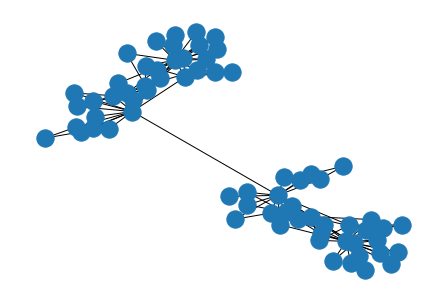

In [123]:
import networkx as nx
import matplotlib.pylab as plt

karate_1 = nx.karate_club_graph()
karate_2 = nx.karate_club_graph()

# relabel nodes to create disjoint nodes
karate_1 = nx.convert_node_labels_to_integers(karate_1, first_label=0)
print(len(karate_1))
karate_2 = nx.convert_node_labels_to_integers(karate_2, first_label=len(karate_1))

joint_graph = nx.compose(karate_1, karate_2)
print(len(joint_graph))

joint_graph.add_edge(0, 34)

nx.draw(joint_graph)
plt.show()

In [124]:
G = nx.complete_multipartite_graph(28, 16, 10)
pos = nx.multipartite_layout(G)

In [253]:
for i in range(1,1):
    print(i)

1
